This script's primary purpose is to explore the impact of different normalization techniques on the training of neural network language models. The script sets up an entire process, from preparing a dataset to training models with distinct normalization methods, and finally analyzing the training outcomes through visualizations.

The process begins by constructing a vocabulary from a text corpus, ensuring only frequently occurring words are included. This vocabulary then feeds into creating datasets for language modeling, which are set up for training, validation, and testing phases.

The core of the script is the definition and training of neural network models. Three variations of a language model are constructed: one without any normalization, one with Layer Normalization, and one with Batch Normalization. These models are composed of custom linear, ReLU, and either LayerNorm or BatchNorm layers, all orchestrated within a LanguageModel class that predicts word probabilities.

Each model is then trained on the prepared dataset. During training, the script captures both the loss and a specific gradient statistic. This statistic is crucial as it measures the scale of the gradients relative to the parameters, offering insights into how each model's training progresses.

Finally, the script visualizes the gradient distributions for each model. This visualization is key to understanding the script's purpose: it clearly demonstrates the effect of different normalization techniques on the stability of the training process. By comparing the gradient distributions, the script showcases how normalization can influence the learning dynamics of neural networks, particularly in language modeling tasks. This comparison is intended to reveal how normalization leads to more consistent and stable gradients during training.

Imports necessary libraries

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ExponentialLR
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import random
from nltk.tokenize import sent_tokenize, word_tokenize
from collections import defaultdict, Counter
import string
import math
import sys
import logging
from datetime import datetime
import yaml
import json
import string
import math
import sys
import logging
from datetime import datetime
import yaml



Reads in the configuration

In [ ]:
with open("gradientDistributionConfiguration.yaml", 'r') as ymlfile:
    config = yaml.safe_load(ymlfile)

training_data_corpus_path = config['data']['training_data_corpus_path']
validation_data_corpus_path = config['data']['validation_data_corpus_path']
test_data_corpus_path = config['data']['test_data_corpus_path']
min_freq = config['data']['min_freq']
context_size = config['data']['context_size']

shuffle = config['runtime']['shuffle']
num_workers = config['runtime']['num_workers']
batch_size = config['runtime']['batch_size']
config_device = config['runtime']['device']


total_epochs = config['experiment']['total_epochs']
lr_start = config['hyperparameters']['lr_start']
lr_end = lr_start * config['hyperparameters']['reduction_factor']
weight_decay = config['hyperparameters']['weight_decay']
reduction_factor = config['hyperparameters']['reduction_factor']
numberOfLayers = config['hyperparameters']['numberOfLayers'] # Number of hidden layers
embed_size = config['hyperparameters']['embed_size']  # The embedding size of the words
hidden_size = config['hyperparameters']['hidden_size'] # The hidden size of the neural network


In [ ]:
class WikiText2VocabBuilder:
    def _new_index(self):
        return len(self.word2index)

    def __init__(self, corpus_path, min_freq):
        self.corpus_path = corpus_path
        self.min_freq = min_freq
        self.word2index = defaultdict(self._new_index)
        self.index2word = {}
        self.word_freqs = Counter()
        self.cleaned_sentences = []

        self.START_TOKEN = "<s>"
        self.END_TOKEN = "</s>"
        self.UNK_TOKEN = "<unk>"
        self.hyphentoken = "hyphentoken"
        self.numericalcommatoken = "numericalcommatoken"

        self._initialize_special_tokens()
        self._load_and_preprocess()

    def _initialize_special_tokens(self):
        self.word2index[self.START_TOKEN] = 0
        self.word2index[self.END_TOKEN] = 1
        self.word2index[self.UNK_TOKEN] = 2
        self.word2index[self.hyphentoken] = 3
        self.word2index[self.numericalcommatoken] = 4

        self.index2word[0] = self.START_TOKEN
        self.index2word[1] = self.END_TOKEN
        self.index2word[2] = self.UNK_TOKEN
        self.index2word[3] = self.hyphentoken
        self.index2word[4] = self.numericalcommatoken


    def clean_and_tokenize(self, corpus):
        corpus = corpus.lower()  # Convert to lowercase
        sentences = sent_tokenize(corpus)
        cleaned_sentences = []
        for sentence in sentences:
            sentence = sentence.strip()  # Remove unnecessary whitespaces
            if not (sentence.startswith('=') or sentence.endswith('=')):  # Exclude headers
                sentence = sentence.replace('<unk>', 'unknowntoken')
                sentence = sentence.replace('@-@', 'hyphentoken')
                sentence = sentence.replace('@,@', 'numericalcommatoken')
                cleaned_sentences.append(sentence)
        return cleaned_sentences

    def _load_and_preprocess(self):
        with open(self.corpus_path, 'r') as f:
            corpus = f.read()

        # Split the text into sentences using NLTK
        self.cleaned_sentences = self.clean_and_tokenize(corpus)
        # Count word frequencies
        for sentence in self.cleaned_sentences:
            words = word_tokenize(sentence)
            for word in words:
                word = word.lower()
                self.word_freqs[word] += 1

        # Build the vocabulary using only words that meet the frequency threshold
        for word, freq in self.word_freqs.items():
            if freq >= self.min_freq:
                index = self.word2index[word]
                self.index2word[index] = word

    def vocab_size(self):
        return len(self.word2index)




---

The `WikiText2Dataset` class inherits from PyTorch's `Dataset` and is tailored for creating a dataset suitable for language modeling tasks. It receives a preprocessor object with cleaned sentences and vocabulary mappings, which it uses to prepare the training data. The class defines methods for constructing the dataset by converting words into indices based on the context size, accessing dataset length, retrieving specific data samples, and sampling random instances from the dataset. Special tokens are managed during dataset construction, ensuring that punctuation and special characters are appropriately handled.

---

In [ ]:
class WikiText2Dataset(Dataset):
    def __init__(self, preprocessor, context_size):
        super(WikiText2Dataset, self).__init__()

        self.context_size = context_size

        # We already have cleaned sentences in the preprocessor
        self.sentences = preprocessor.cleaned_sentences
        self.word2index = preprocessor.word2index
        self.index2word = preprocessor.index2word
        self.word_freqs = preprocessor.word_freqs
        self.START_TOKEN = preprocessor.START_TOKEN
        self.END_TOKEN = preprocessor.END_TOKEN
        self.UNK_TOKEN = preprocessor.UNK_TOKEN
        self.hyphentoken = preprocessor.hyphentoken
        self.numericalcommatoken = preprocessor.numericalcommatoken


        self.X, self.Y = self._build_dataset()

    def _build_dataset(self):
        X, Y = [], []

        for sentence in self.sentences:
            words = word_tokenize(sentence)
            if not words:
                continue
            if words[-1] in string.punctuation:
                words[-1] = self.END_TOKEN
            else:
                words.append(self.END_TOKEN)

            context = [0] * self.context_size
            for i, word in enumerate(words):

                if word in self.word2index and word not in ['unknowntoken', 'hyphentoken', 'numericalcommatoken']:
                    index = self.word2index[word]
                elif word == 'unknowntoken':
                    index = self.word2index[self.UNK_TOKEN]
                elif word == 'hyphentoken':
                    index = self.word2index[self.hyphentoken]
                elif word == 'numericalcommatoken':
                   index = self.word2index[self.numericalcommatoken]
                else:
                    index = self.word2index[self.UNK_TOKEN]
                X.append(context)
                Y.append(index)
                context = context[1:] + [index]

        return torch.tensor(X), torch.tensor(Y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.Y[index]

    def sample(self, num_samples):
        for _ in range(num_samples):
            idx = torch.randint(0, len(self), (1,)).item()
            context, target = self.X[idx], self.Y[idx]
            context_words = [self.index2word[i.item()] for i in context]
            target_word = self.index2word[target.item()]
            print(" ".join(context_words), "------>", target_word)

    def get_context_size(self):
        return self.context_size



---

The code initializes the `WikiText2VocabBuilder` to build a vocabulary from the training corpus and creates three datasets for the training, validation, and testing phases using the `WikiText2Dataset` class with the generated vocabulary and specified context size.

---

In [ ]:
train_vocabBuilder =  WikiText2VocabBuilder(corpus_path = training_data_corpus_path, min_freq=min_freq)

train_dataset = WikiText2Dataset(train_vocabBuilder, context_size = context_size)
valid_dataset = WikiText2Dataset(train_vocabBuilder, context_size = context_size)
test_dataset = WikiText2Dataset(train_vocabBuilder, context_size = context_size)


---

This section of code leverages PyTorch's `DataLoader` to create iterators for the training, validation, and testing datasets, enabling efficient batch processing with options for shuffling and parallel data loading using multiple workers.

---

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)



---

The code defines a neural network architecture for a language model, consisting of custom linear, ReLU, LayerNorm, and BatchNorm modules, and an overarching LanguageModel class. The LanguageModel uses an embedding layer, multiple configurable hidden layers with optional normalization, and an output layer to predict word probabilities in a given context.

---

In [ ]:
class Linear(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Linear, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.weight = nn.Parameter(torch.Tensor(self.input_dim, self.output_dim))
        self.bias = nn.Parameter(torch.Tensor(self.output_dim))
        for param in self.parameters():
            param.requires_grad = True

        self.reset_parameters()

    def reset_parameters(self):
        nn.init.uniform_(self.weight, -10, 10)  # Use high variance
        nn.init.constant_(self.bias, 0)

    def forward(self, x):
        self.out = torch.matmul(x, self.weight) + self.bias
        return self.out

class ReLU(nn.Module):
    def __init__(self):
        super(ReLU, self).__init__()


    def forward(self, x):
        self.out = torch.clamp(x, min=0)
        self.out.retain_grad()
        return self.out

class LayerNorm(nn.Module):
    def __init__(self, hidden_size):
        super(LayerNorm, self).__init__()
        self.hidden_size = hidden_size
        self.weight = nn.Parameter(torch.Tensor(self.hidden_size))
        self.bias = nn.Parameter(torch.Tensor(self.hidden_size))
        for param in self.parameters():
            param.requires_grad = True

        self.reset_parameters()

    def reset_parameters(self):
        nn.init.constant_(self.weight, 1)
        nn.init.constant_(self.bias, 0)

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        std = x.std(dim=-1, keepdim=True)
        self.out = self.weight * (x - mean) / (std + 1e-8) + self.bias
        return self.out

class BatchNorm(nn.Module):
    def __init__(self, hidden_size):
        super(BatchNorm, self).__init__()
        self.hidden_size = hidden_size
        self.weight = nn.Parameter(torch.Tensor(self.hidden_size))
        self.bias = nn.Parameter(torch.Tensor(self.hidden_size))
        for param in self.parameters():
            param.requires_grad = True

        self.reset_parameters()

    def reset_parameters(self):
        nn.init.constant_(self.weight, 1)
        nn.init.constant_(self.bias, 0)

    def forward(self, x):
        mean = x.mean(dim=0, keepdim=True)
        std = x.std(dim=0, keepdim=True)
        self.out = self.weight * (x - mean) / (std + 1e-8) + self.bias
        return self.out

class LanguageModel(nn.Module):

    def __init__(self, vocab_size, embed_size, hidden_size, context_size, numberOfLayers, norm):
        super(LanguageModel, self).__init__()
        self.embed_size = embed_size
        self.context_size = context_size
        self.hidden_size = hidden_size
        self.numberOfLayers = numberOfLayers
        self.vocab_size = vocab_size
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.hidden_layers = nn.ModuleList()


        # Hidden layers weights, bias, and layer normalization
        for i in range(self.numberOfLayers):
            linear_layer = Linear((self.context_size) * self.embed_size if i == 0 else self.hidden_size, self.hidden_size)
            reLU_layer = ReLU()
            layers = [linear_layer]

            if norm == 'layer':
                normLayer = LayerNorm(self.hidden_size)
                layers.append(normLayer)
            elif norm == 'batch':
                normLayer = BatchNorm(self.hidden_size)
                layers.append(normLayer)

            layers.append(reLU_layer)


            self.hidden_layers.append(nn.Sequential(*layers))


        self.output_layer = nn.Linear(self.hidden_size, self.vocab_size)

        with torch.no_grad():
            # Make the output layer less confident
            nn.init.constant_(self.output_layer.weight, 0.01)
            nn.init.constant_(self.output_layer.bias, 0)

        # Collect all parameters to be optimized
        parameters = [self.embedding.weight] + \
            [param for layer in self.hidden_layers for param in list(layer.parameters())] + \
            [self.output_layer.weight, self.output_layer.bias]

        self.parameters = nn.ParameterList(parameters)


    def forward(self, x):
        x = self.embedding(x) # Retrieve the corresponding embeddings
        x = x.view(x.size(0), -1)

        for hidden_layer in self.hidden_layers:

            x = hidden_layer(x)

        # Output layer computation. The output is of shape (batch_size, vocab_size)
        y = self.output_layer(x)

        # Log probabilities (logits). Log probs is of shape (batch_size, vocab_size)
        log_probs = F.log_softmax(y, dim=1)

        return log_probs

    def num_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)


---

This function trains a language model for exactly 1000 steps, rather than full epochs. It records the log-transformed loss at each step. Additionally, it calculates and logs a unique statistic, `ud`, which represents the log10 of the standard deviation ratio of the learning rate-scaled gradients to the standard deviations of the model's parameters, offering a measure of the learning rate's effect on parameter updates.

---

In [ ]:

def train_language_model(model, train_dataloader, valid_dataloader, test_dataloader, device, total_epochs, start_lr, end_lr, weight_decay_value):
    loss_function = nn.NLLLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=start_lr, weight_decay=weight_decay_value)
    scheduler = ExponentialLR(optimizer, gamma=(end_lr/start_lr)**(1/total_epochs))
    lossi = []
    ud = []

    max_steps = 1000
    train_dataloader_iterator = iter(train_dataloader)


    for i in range(max_steps):
        try:
        # Fetch the next batch of data
           contexts, targets = next(train_dataloader_iterator)
        except StopIteration:
            # Reinitialize the iterator if the entire dataset has been processed
            train_dataloader_iterator = iter(train_dataloader)
            contexts, targets = next(train_dataloader_iterator)


        # Move the data to the GPU
        contexts, targets = contexts.to(device), targets.to(device)
        log_probs = model(contexts)
        loss = loss_function(log_probs, targets)

        for layer in model.hidden_layers:
            for hidden_layer in layer:
                if isinstance(hidden_layer, Linear):
                    hidden_layer.out.retain_grad()


        for p in model.parameters():
            if p.grad is not None:
                p.grad.zero_()

        # Backward pass
        loss.backward()
        optimizer.step()

        lossi.append(loss.log10().item())
        # Inside your while loop, after the backward pass
        with torch.no_grad():
            lr = scheduler.get_last_lr()[0]
            ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in [p for p in model.parameters()]])

    return lossi, ud



---

This code block sets up the environment for training language models with fixed seeds for reproducibility and determines the computation device based on hardware availability. Three models with different normalization techniques ('none', 'layer', 'batch') are instantiated and trained for  1000 steps, capturing training statistics and update distributions. Results are stored to assess the impact of normalization on training dynamics.

---

In [ ]:

vocab_size = train_vocabBuilder.vocab_size() # The size of the vocabulary

# Initialize device based on the configuration and availability
device = torch.device(config_device if torch.cuda.is_available() else "cpu")
device_msg = f"Using device {device}"
print(device_msg)
valid_perplexities_dict = {}
test_perplexity_dict = {}

np.random.seed(423455335)
# Set the seed for generating random numbers
torch.manual_seed(423455335)
# Set the seed for generating random numbers for CUDA when using the GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Initialize the dictionary that will hold all the data
results_dict = {}


model = LanguageModel(vocab_size, embed_size, hidden_size, context_size, numberOfLayers, norm='none')
layerModel = LanguageModel(vocab_size, embed_size, hidden_size, context_size, numberOfLayers, norm='layer')
batchModel = LanguageModel(vocab_size, embed_size, hidden_size, context_size, numberOfLayers, norm='batch')

model = model.to(device)
lossi, ud =  train_language_model(model=model, train_dataloader=train_dataloader, valid_dataloader=valid_dataloader, test_dataloader=test_dataloader, device=device, total_epochs=total_epochs, start_lr=lr_start, end_lr=lr_end, weight_decay_value=weight_decay)

layerModel = layerModel.to(device)
layerLossi, layerUd =  train_language_model(model=layerModel, train_dataloader=train_dataloader, valid_dataloader=valid_dataloader, test_dataloader=test_dataloader, device=device, total_epochs=total_epochs, start_lr=lr_start, end_lr=lr_end, weight_decay_value=weight_decay)

batchModel = batchModel.to(device)
batchLossi, batchUd =  train_language_model(model=batchModel, train_dataloader=train_dataloader, valid_dataloader=valid_dataloader, test_dataloader=test_dataloader, device=device, total_epochs=total_epochs, start_lr=lr_start, end_lr=lr_end, weight_decay_value=weight_decay)



Using device cuda


In [ ]:
batchLossi = math.exp(batchLossi[-1])
layerLossi = math.exp(layerLossi[-1])
lossi = math.exp(lossi[-1])

print("batchLossi", batchLossi)
print("layerLossi", layerLossi)
print("lossi", lossi)


batchLossi 2.3001979312906746
layerLossi 2.350719862644213
lossi 810630445.1203386




---

The code computes and plots the gradient distributions for three variations of a neural network model: one without normalization, one with Layer Normalization, and one with Batch Normalization. In the accompanying image, the 'Original' model's gradients show considerable dispersion across layers, which could lead to instability during training. The 'LayerNorm' and 'BatchNorm' models demonstrate significantly tighter gradient distributions, indicating that these normalization techniques are effective at stabilizing gradients. The plot uses a logarithmic scale on the Y-axis to accentuate the differences in gradient magnitudes, with the normalization clearly demonstrating a beneficial effect on the consistency of gradient scales across different layers.

---

Model: Original
   Average Lower 25% range: -5.17e+14 to -5.48e+13
   Average Upper 25% range: 5.64e+13 to 6.79e+14
Model: LayerNorm
   Average Lower 25% range: -3.99e-03 to -3.13e-04
   Average Upper 25% range: 3.21e-04 to 3.87e-03
Model: BatchNorm
   Average Lower 25% range: -8.29e-03 to -7.97e-04
   Average Upper 25% range: 8.04e-04 to 8.18e-03


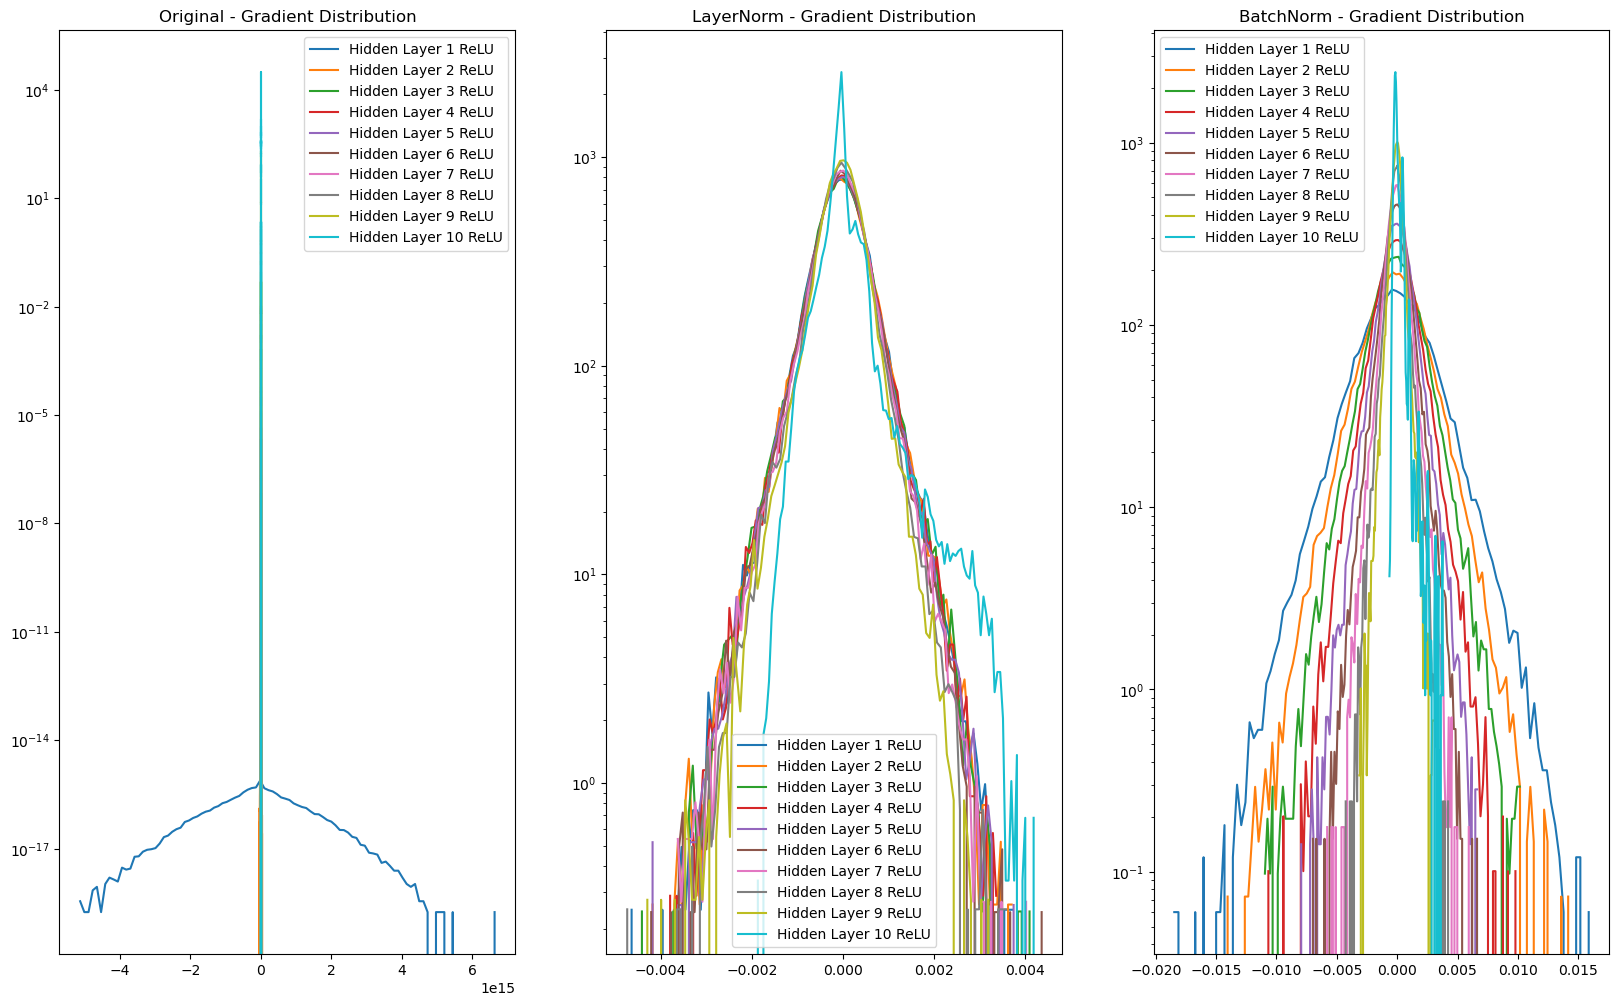

In [ ]:

import matplotlib.pyplot as plt
import numpy as np
import torch



def compute_statistics(tensor):
    """Compute statistics for a tensor."""
    data = tensor.cpu().numpy()
    return {
        "Lower 25%": (data.min(), np.percentile(data, 25)),
        "Upper 25%": (np.percentile(data, 75), data.max()),
    }


plt.figure(figsize=(20, 12))  # Increased figure size for better visibility

# Subplots for each model
for idx, (model, title) in enumerate([(model, 'Original'), (layerModel, 'LayerNorm'), (batchModel, 'BatchNorm')]):
    lower_25_ranges = []
    upper_25_ranges = []

    plt.subplot(1, 3, idx + 1)
    legends = []

    for i, hidden_layer in enumerate(model.hidden_layers):
        for j, layer in enumerate(hidden_layer):
            if isinstance(layer, ReLU):
                if hasattr(layer, 'out'):
                    t = layer.out.grad
                    if t is not None:
                        t = t.cpu()
                        if t is not None:
                            statistics = compute_statistics(t)
                            lower_25_ranges.append(statistics["Lower 25%"])
                            upper_25_ranges.append(statistics["Upper 25%"])

                        hy, hx = torch.histogram(t, density=True)
                        plt.semilogy(hx[:-1].detach(), hy.detach())  # Log scale for Y-axis


                        legends.append(f'Hidden Layer {i+1} ReLU')

    plt.legend(legends)
    plt.title(f'{title} - Gradient Distribution')
    # Calculate the average ranges
    avg_lower_25_range = np.mean(lower_25_ranges, axis=0)
    avg_upper_25_range = np.mean(upper_25_ranges, axis=0)

    print(f"Model: {title}")
    print(f"   Average Lower 25% range: {avg_lower_25_range[0]:.2e} to {avg_lower_25_range[1]:.2e}")
    print(f"   Average Upper 25% range: {avg_upper_25_range[0]:.2e} to {avg_upper_25_range[1]:.2e}")
# Save the plot as a PNG file
plt.savefig('gradient_distributionMultipleNorms.png')

# Display the plot
plt.show()


